# Surfs Up!

Congratulations! You've decided to treat yourself to a long holiday vacation in Honolulu, Hawaii! To help with your trip planning, you need to do some climate analysis on the area. 

In [1]:
# Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
from dateutil.relativedelta import relativedelta

In [2]:
import matplotlib
matplotlib.__version__

'3.0.3'

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create session (link) from Python to the DB
session = Session(engine)

In [9]:
# List columns for Measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# List 5 rows for Measurement table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# List columns for Station table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# List 5 rows for Station table
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

## Precipitation Analysis

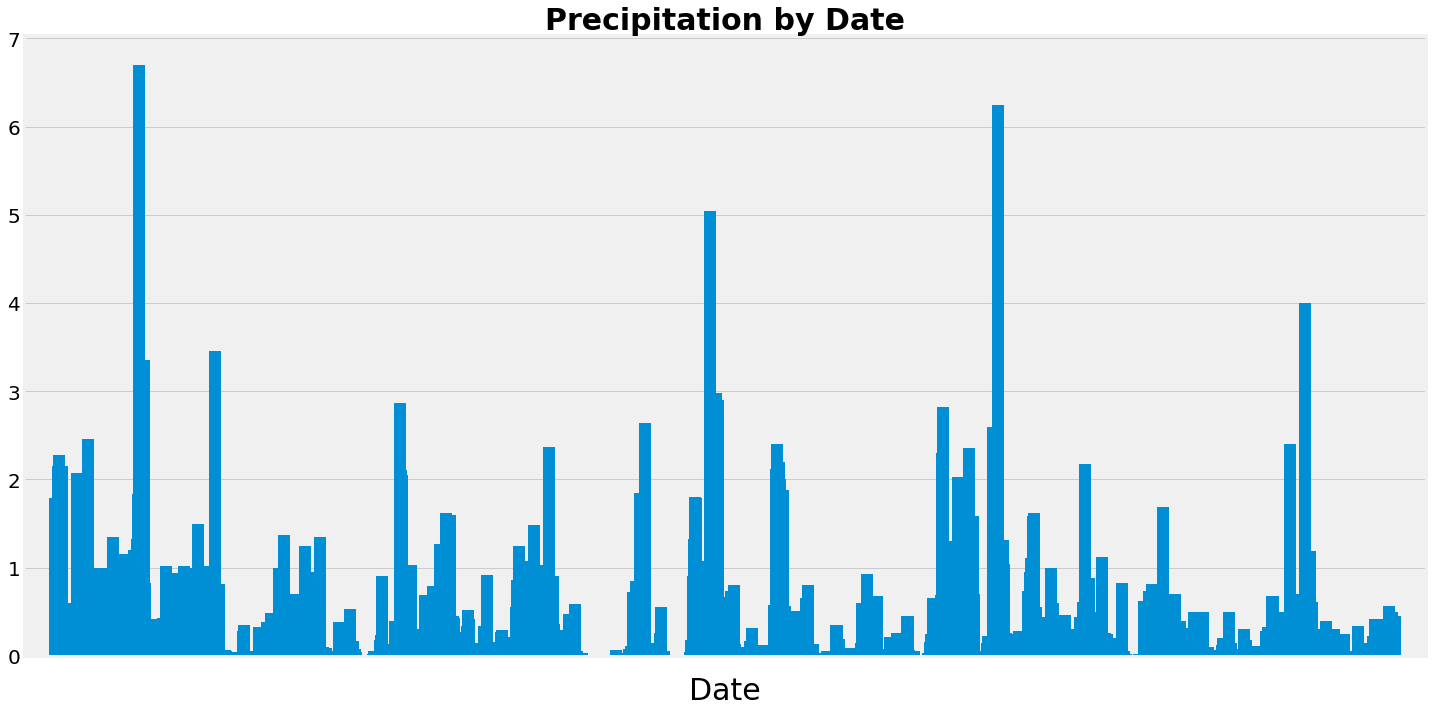

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find last data point date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(last_date[0], '%Y-%m-%d').date() - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.read_sql(session.query(Measurement.date, Measurement.prcp).\
                      filter(Measurement.date >= year_ago).statement,session.bind)
df_prcp.columns = ['date', 'precipitation']
df_prcp = df_prcp.set_index('date')

# Sort the dataframe by date
df_prcp = df_prcp.sort_values('date')

# Find munber of precipitaion records for plotting 
right = df_prcp.shape[0]

# Use Pandas Plotting with Matplotlib to plot the data
df_prcp.plot(kind = 'bar', figsize=(20,10), legend = False, width = 20)
plt.title('Precipitation by Date', fontsize=30, weight = 'bold')
plt.xlim(-50, right + 50)
plt.yticks(fontsize=20)
plt.xticks([])
plt.xlabel('Date', fontsize=30, labelpad = 20)
plt.tight_layout()
plt.show()

In [58]:
# Summary statistics for the precipitation data
df_prcp.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [59]:
# Design a query to show how many stations are available in this dataset?
station_number = session.query(Station.station).count()
print(f"There are {station_number} stations in this dataset.")

There are 9 stations in this dataset.


In [60]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                         group_by(Measurement.station).\
                         order_by(func.count(Measurement.station).desc())
for station in active_stations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [61]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
first_station = active_stations[0][0]
station_stats = session.query(Measurement.station, 
                        func.min(Measurement.tobs).label("min_temp"),
                        func.max(Measurement.tobs).label("max_temp"),
                        func.avg(Measurement.tobs).label("avg_temp")).\
                        filter(Measurement.station == first_station).\
                        group_by(Measurement.station)
for stats in station_stats:
    print(f"Station: {stats.station}")
    print(f"Lowest Temperature: {stats.min_temp}")
    print(f"Highest Temperature: {stats.max_temp}")
    print(f"Average Temperature: {stats.avg_temp:4.2f}")

Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


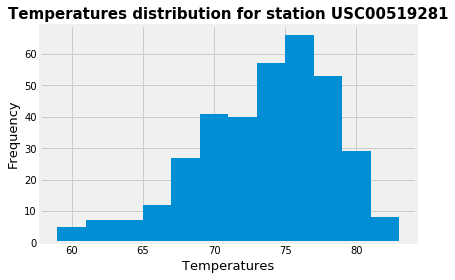

In [62]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = session.query(Measurement.tobs).\
                       filter(Measurement.date >= year_ago).\
                       filter(Measurement.station == first_station).\
                       all()
# Extract temperatures
temps = np.ravel(temperatures)

# Plt Histogram
plt.hist(temps, bins = 12)
plt.title(f"Temperatures distribution for station {first_station}", fontsize = 15, weight = 'bold')
plt.ylabel('Frequency', fontsize = 13)
plt.xlabel('Temperatures', fontsize = 13)
plt.show()

## Temperature Analysis

In [63]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
   
    return session.query(func.min(Measurement.tobs), 
                         func.max(Measurement.tobs), 
                         func.avg(Measurement.tobs)).\
                         filter(Measurement.date >= start_date).\
                         filter(Measurement.date <= end_date).\
                         all()

In [64]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_dt = '2015-08-01'
end_dt = '2015-08-15'

# Calculate the date 1 year ago from the start date
st_year_ago = dt.datetime.strptime(start_dt, '%Y-%m-%d').date() - relativedelta(years=1)
print(f"Start date 1 year ago: {st_year_ago}")

# Calculate the date 1 year ago from the end date
end_year_ago = dt.datetime.strptime(end_dt, '%Y-%m-%d').date() - relativedelta(years=1)
print(f"End date 1 year ago: {end_year_ago}")

# Calculate temperatures
results = calc_temps(st_year_ago, end_year_ago)

results = np.ravel(results)

min_temp = results[0]
max_temp = results[1]
avg_temp = results[2]

print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp:4.2f}")

Start date 1 year ago: 2014-08-01
End date 1 year ago: 2014-08-15
Lowest Temperature: 68.0
Highest Temperature: 83.0
Average Temperature: 76.79


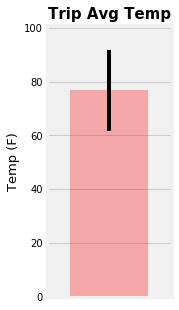

In [65]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize = (2,5))
plt.bar(1, avg_temp, width = 0.05, color = 'red', alpha = 0.3)
plt.errorbar(1, avg_temp, max_temp - min_temp, color = 'black')
plt.xlim(0.96, 1.04)
plt.ylim(0,101)
plt.xticks([])
plt.ylabel("Temp (F)", fontsize = 13)
plt.title('Trip Avg Temp', fontsize = 15, weight = 'bold')
plt.show()

## Daily Rainfall Average

In [66]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
stations_rainfall = session.query(Station.station,
                                  Station.name,
                                  Station.latitude,
                                  Station.longitude,
                                  Station.elevation,
                                  func.sum(Measurement.prcp).label("tot_prcp")).\
                         filter(Measurement.station == Station.station).\
                         filter(Measurement.date >= st_year_ago).\
                         filter(Measurement.date <= end_year_ago).\
                         group_by(Station.station,
                                  Station.name,
                                  Station.latitude,
                                  Station.longitude,
                                  Station.elevation).\
                         order_by(func.sum(Measurement.prcp).desc()).\
                         all()

for station in stations_rainfall:
    print(f"Station: {station.station}")
    print(f"Name: {station.name}")
    print(f"Latitude: {station.latitude}")
    print(f"Longitude: {station.longitude}")
    print(f"Elevation: {station.elevation}")
    print(f"Rainfall Amount: {station.tot_prcp:4.2f}")
    print("-----------------------------------------")

Station: USC00516128
Name: MANOA LYON ARBO 785.2, HI US
Latitude: 21.3331
Longitude: -157.8025
Elevation: 152.4
Rainfall Amount: 4.32
-----------------------------------------
Station: USC00514830
Name: KUALOA RANCH HEADQUARTERS 886.9, HI US
Latitude: 21.5213
Longitude: -157.8374
Elevation: 7.0
Rainfall Amount: 1.78
-----------------------------------------
Station: USC00519281
Name: WAIHEE 837.5, HI US
Latitude: 21.45167
Longitude: -157.84888999999998
Elevation: 32.9
Rainfall Amount: 1.76
-----------------------------------------
Station: USC00513117
Name: KANEOHE 838.1, HI US
Latitude: 21.4234
Longitude: -157.8015
Elevation: 14.6
Rainfall Amount: 1.00
-----------------------------------------
Station: USC00519523
Name: WAIMANALO EXPERIMENTAL FARM, HI US
Latitude: 21.33556
Longitude: -157.71139
Elevation: 19.5
Rainfall Amount: 0.75
-----------------------------------------
Station: USC00511918
Name: HONOLULU OBSERVATORY 702.2, HI US
Latitude: 21.3152
Longitude: -157.9992
Elevation: 0.

## Optional Challenge Assignment

In [67]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [68]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_dt = '2015-08-01'
end_dt = '2015-08-15'

start_dt = dt.datetime.strptime(start_dt, '%Y-%m-%d').date()
end_dt = dt.datetime.strptime(end_dt, '%Y-%m-%d').date()

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
loop_date = start_dt
date_range = []
while loop_date <= end_dt:
    date_range.append(loop_date)
    loop_date = loop_date + relativedelta(days=1)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for dates in date_range:
    normals.append(np.ravel(daily_normals(dates.strftime("%m-%d"))))

In [69]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_daily_temps = pd.DataFrame(normals, date_range, ["min temp", "avg temp", "max temp"])
df_daily_temps

,min temp,avg temp,max temp
2015-08-01,67.0,75.540000,83.0
2015-08-02,68.0,75.603774,84.0
2015-08-03,70.0,76.611111,85.0
2015-08-04,69.0,76.711538,84.0
2015-08-05,69.0,76.148148,82.0
2015-08-06,67.0,76.250000,83.0
2015-08-07,71.0,77.156863,83.0
2015-08-08,68.0,76.557692,83.0
2015-08-09,69.0,75.980392,81.0
2015-08-10,65.0,76.420000,83.0


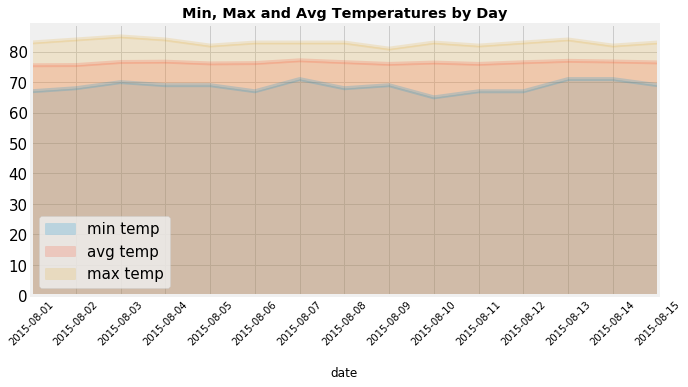

In [76]:
# Plot the daily normals as an area plot with `stacked=False`
df_daily_temps.plot(kind='area', figsize=(10,5),  stacked = False, alpha = 0.2 )
plt.xlabel('date', labelpad = 20)
plt.yticks(fontsize = 15)
xtick_labels = [item.strftime('%Y-%m-%d') for item in df_daily_temps.index]
plt.xticks(df_daily_temps.index, xtick_labels, rotation = 45)
plt.legend(fontsize = 15, frameon = True)
plt.title("Min, Max and Avg Temperatures by Day", weight = 'bold')
plt.show()